Author: Aryan Singh \
This file is ultimately what we are submitting for the checkpoint as it the most working version of the code out of all of us. However, everyone will be submitting their code along side this as well.
I think the objective is to obtain a factor loading matrix. It has no rotations applied on it, however, that would be the next [logical step.](https://stats.oarc.ucla.edu/spss/seminars/introduction-to-factor-analysis/a-practical-introduction-to-factor-analysis/)

### Steps for Factor Analysis using EM
Step 1: Generate data using z, W, $\mu$, $\psi$. Dimensionality should be prime numbers so that its easier to debug.

First I have to create a set of observations that I will test on. Based on a factor analysis model, this set of observations X will have have latent variables z. I can start with z to create a set of observations X based on a linear transformation W, centering at $\mu$ and adding noise $\psi$. Then when I apply factor analysis to X, I can evaluate my models correctness on if $WW^T = W'W'^T$, and $\psi\psi^T = \psi'\psi'^T$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv, det
from sklearn.linear_model import LinearRegression 

In [2]:
N = 103  # Number of observations
M = 3  # Number of latent variables
D = 7 # Number of dimensions of X

First I create z

In [3]:
z = np.random.normal(0, 1, size=(N, M))
z[:5]

array([[ 0.13344444,  0.45643535, -0.4803033 ],
       [-0.19031946,  2.54497609, -0.91342399],
       [ 0.7224282 ,  0.43027718,  0.36101883],
       [-0.68248626, -0.13670232,  0.99401432],
       [ 1.29068734, -0.26409537, -0.2844255 ]])

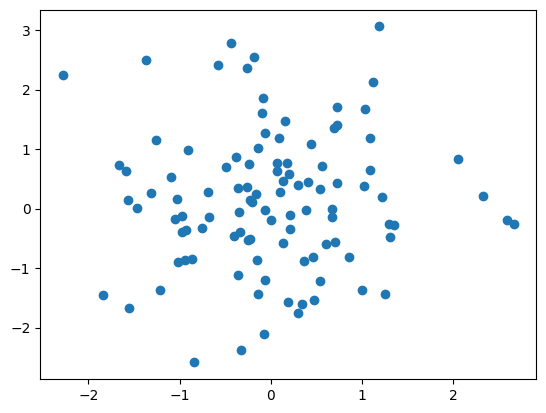

In [4]:
plt.scatter(z[:,0], z[:,1])

Now I apply a set of transformations W to get X. I want X to be a (103, 7) matrix, which means W has to be (7, 3). I will also add some mean $\mu$ and $\psi$ to add noise

In [22]:
W = np.array([[2, 3, 9], [9, 6, 10], [10, 9, 8], [7, 3, 2], [4, 2, 7], [7, 1, 1], [2, 7, 3]])
u = np.array([8, 2, 6, 10, 3, 5, 2])

# based on Mikio SNR, use high lambdas
# I will use low lambdas
psi = np.diag([1, 3, 2, 1, 2, 3, 1]) # Low lambdas (noise) causes weights plot to have a slope of 1
# psi = np.diag([10, 30, 20, 10, 20, 30, 10]) # High lambdas (noise) causes weights plot to not have a slope of 1

noise_ = np.random.multivariate_normal(u, psi, size=(N,))


X = (W @ z.T).T + noise_

X[:5]

array([[ 4.98966944,  2.29332578,  7.78471058, 11.30258207,  0.9349546 ,
         3.76944934,  3.39208038],
       [ 3.91413445,  4.86059851, 17.49610423, 14.92156466,  3.14970819,
         5.41547239, 16.87560671],
       [13.85578772, 16.35421605, 19.02303293, 16.66789884,  9.49695696,
         6.5291111 ,  7.36622402],
       [14.21913098,  5.31493809,  1.63191709,  7.82431719,  6.43718403,
         2.89683039,  2.53795781],
       [ 7.40404739,  8.79771519, 13.32994352, 18.6337765 ,  5.6347562 ,
        12.91870653,  3.24037165]])

I will use the "_L" suffix to denote learned variables. We are going to start with randomly initialized variables.

In [6]:
mu_x = np.mean(X, axis=0).reshape(-1, 1)
W_L = np.random.normal(0, 1, size=(X.shape[1], M))
psi_L = np.diag(np.random.uniform(low=0, high=1, size=X.shape[1]))
G = inv(np.eye(M) + W_L.T @ inv(psi_L) @ W_L)

Expectation Step

In [7]:
Ez_L = np.empty(X.shape[0], dtype=object)
Ezzt_L = np.empty(X.shape[0], dtype=object)

In [8]:
for i in range(0, X.shape[0]):
    Ez_L[i] = G @ W_L.T @ inv(psi_L) @ (X[i].reshape(-1, 1) - mu_x)
    Ezzt_L[i] = G + Ez_L[i] @ Ez_L[i].T

Maximization Step

In [9]:
# Compute new W

w_sum1 = np.zeros(shape=(X.shape[1], M))

for i in range(X.shape[0]):
    w_sum1 += (X[i].reshape(-1, 1) - mu_x) @ Ez_L[i].T

W_L = w_sum1 @ inv(Ezzt_L.sum(axis=0))


In [10]:
# Compute new psi. Assuming S is the sample covariance.

psi_sum1 = np.zeros(shape=(M, X.shape[1]))

for i in range(X.shape[0]):
    psi_sum1 += Ez_L[i] @ (X[i].reshape(-1, 1) - mu_x).T
    
psi_L = np.diag(np.diag(np.cov(X.T) - (1/N) * W_L @ psi_sum1))

### Calculate Likelihood
Here I will define a method to calculate likelihood so that we can measure it over the epochs

In [11]:
def likelihood():
    C = W_L @ W_L.T + psi_L
    return -(N/2) * (np.log(det(C)) + np.trace(np.cov(X.T) * inv(C)))

Now we can put it all together to try and see how close our estimation was to the real W

In [12]:
epochs = 250  # Number of iterations to run EM
M = 3  # Number of latent variables

mu_x = np.mean(X, axis=0).reshape(-1, 1)
W_L = np.random.uniform(low=-5, high=5, size=(X.shape[1], M))
psi_L = np.diag(np.random.uniform(low=0, high=1, size=X.shape[1]))
likelihoods = np.zeros(shape=epochs)

for i in range(epochs):
    # Expectation Step
    Ez_L = np.empty(X.shape[0], dtype=object)
    Ezzt_L = np.empty(X.shape[0], dtype=object)
    G = inv(np.eye(M) + W_L.T @ inv(psi_L) @ W_L)
    
    for j in range(0, X.shape[0]):
        Ez_L[j] = G @ W_L.T @ inv(psi_L) @ (X[j].reshape(-1, 1) - mu_x)
        Ezzt_L[j] = G + Ez_L[j] @ Ez_L[j].T
        
        
    # Compute new W

    w_sum1 = np.zeros(shape=(X.shape[1], M))

    for j in range(X.shape[0]):
        w_sum1 += (X[j].reshape(-1, 1) - mu_x) @ Ez_L[j].T

    W_L = w_sum1 @ inv(Ezzt_L.sum(axis=0))
    
    
    # Compute new psi. Assuming S is the sample covariance.

    psi_sum1 = np.zeros(shape=(M, X.shape[1]))

    for j in range(X.shape[0]):
        psi_sum1 += Ez_L[j] @ (X[j].reshape(-1, 1) - mu_x).T
        
    psi_L = np.diag(np.diag(np.cov(X.T) - (1/N) * W_L @ psi_sum1))
    
    likelihoods[i] = likelihood()

In [13]:
W_L, W

(array([[ -5.64245166,   4.29152753,   4.86127079],
        [-10.62708762,   1.10240035,   8.82805431],
        [ -9.7828345 ,  -1.66278175,  10.90595699],
        [ -5.85497819,  -2.61755251,   4.25002568],
        [ -6.34312403,   2.46516805,   4.25369876],
        [ -5.85249361,  -3.01155949,   2.6076718 ],
        [ -1.98245563,  -0.97677863,   6.52763891]]),
 array([[ 2,  3,  9],
        [ 9,  6, 10],
        [10,  9,  8],
        [ 7,  3,  2],
        [ 4,  2,  7],
        [ 7,  1,  1],
        [ 2,  7,  3]]))

### Check if W and $\psi$ are correct
First get $WW^T$ and $W'W'^T$ and flatten them. Then plot them. Their slope should equal 1 if our EM model is correct

Slope:  0.8508752144273237
Intercept:  6.088960480712785


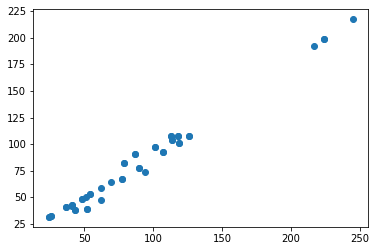

In [14]:
mdl = LinearRegression().fit(np.ndarray.flatten(W @ W.T).reshape(-1, 1), np.ndarray.flatten(W_L @ W_L.T))
print("Slope: ", mdl.coef_[0])
print("Intercept: ", mdl.intercept_)

plt.scatter(x=np.ndarray.flatten(W @ W.T), y=np.ndarray.flatten(W_L @ W_L.T))

Since our slope is 1, we are confident that the Weights portion of our EM is correct

Slope:  0.9681030585570354
Intercept:  -0.15994503807696958


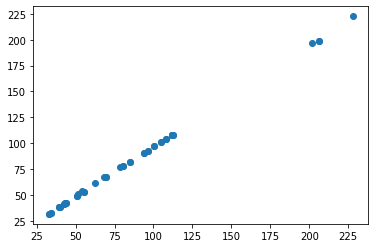

In [15]:
mdl = LinearRegression().fit(np.ndarray.flatten(np.cov(X.T)).reshape(-1, 1), np.ndarray.flatten(W_L @ W_L.T + psi_L))
print("Slope: ", mdl.coef_[0])
print("Intercept: ", mdl.intercept_)

plt.scatter(x=np.ndarray.flatten(np.cov(X.T)), y=np.ndarray.flatten(W_L @ W_L.T + psi_L))

The model we fit is $\Sigma = W'W'^T + \psi$ \
The evaluation criteria we are using here is $W'W'^T + \psi = S$. \
We can measure the slope or residual between these 2 variables to see how well our model is performing.
This evaluation criteria is from page 6 of Statistics of Factor Analysis

### Evaluate Likelihood over epochs
Graph of negative log likelihood (neglecting terms constant with respect to $\psi$)

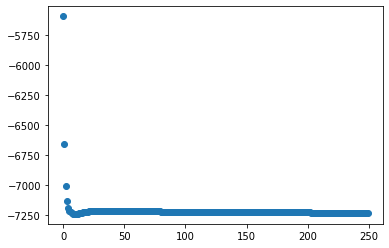

In [16]:
plt.scatter(x= range(epochs), y= likelihoods)

In [17]:
likelihoods[-5:]

array([-7231.78062109, -7231.79661204, -7231.81240742, -7231.8280097 ,
       -7231.84342128])

### How did I make sure the coding was done correctly?
For any problems I was having, I would look up the numpy documentation to see if the behavior I was getting was right.

### How I made sure the math I was doing was correct?

The biggest thing was to always make sure that my matrix dimensions were correct. After this, I just trusted the formulas in the book. I would also keep printing the output of steps along the way to make sure everything was correct.

### How did I plan my coding to be right?
My plan was to reverse engineer a set of latent weights. This way I had a concrete dataset that I could compare my output to, so that I could see if the model was working correctly. Other steps included using for loops instead of matrix operations. I understand matrix operations, however I do not understand the math enough to apply them to this scenario, so I stuck with loops to minimize any errors. I sacrifice run time, but it should have less problems.